In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from queue import *

import numpy as np

# I. Data Processing and Clean up

In [26]:
# Download the caregiver tickets, limit columns, and filter out voicemail tickets.
df = pd.read_csv('ticket_export.csv')
caregivers = df[['Ticket Number','Summary','Description','Category','Auto Response Used',\
                 'Automated Response?']].iloc[4352:]
f1 = caregivers['Automated Response?'].notnull()
emails = caregivers[f1]

# Concatenate the Summary and Description columns into one column.
full_message = []
for i in range(len(emails)):
    message = emails['Summary'].values[i] + " " + emails['Description'].values[i]
    full_message.append(message)
emails.insert(3,'Message',full_message)

In [27]:
# Function to add column for automated reponses to be numerical and categorical. 
def responses(df):
    auto_response = np.zeros(len(df))
    category_response = []

    for i in range(len(df)):
        response = str(df['Auto Response Used'].values[i])
        if response == 'SPAM':
            auto_response[i] = 1
            category_response.append('Spam')
        elif response == '1' or response == '2' or response == '3' or response == '1.0'\
        or response == '2.0' or response == '3.0':
            auto_response[i] = 2
            category_response.append('CCT Registration')
        elif response == '4' or response == '5' or response == '4.0' or response == '5.0':
            auto_response[i] = 3
            category_response.append('CCT Online Registration')
        elif response == '6' or response == '6.0':
            auto_response[i] = 4
            category_response.append('CCT Online Coaching Session')
        elif response == '8' or response == '7' or response == '9' or response == '8.0'\
        or response == '7.0' or response == '9.0':
            auto_response[i] = 5
            category_response.append('General Course Registration')
        elif response == '12' or response == '13' or response == '12.0' or response == '13.0':
            auto_response[i] = 6
            category_response.append('Password Reset')
        elif response == '14' or response == '14.0':
            auto_response[i] = 7
            category_response.append('CCT Couple')
        else: # response is NaN
            auto_response[i] = 0
            category_response.append('No Scripted Response')
    df.insert(len(df.columns),'Auto_Response',auto_response)
    df.insert(len(df.columns),'Script_Title',category_response)
    return df

# Add columns for numerical and categorical auto responses.
responses(emails)
emails.tail()

,Ticket Number,Summary,Description,Message,Category,Auto Response Used,Automated Response?,Auto_Response,Script_Title
7884,7953,accidental registration,Hi!\n\nI was trying to figure out how much the...,accidental registration Hi!\n\nI was trying to...,Cancelation,NaN,No,0.0,No Scripted Response
7885,7954,Technology Users Approach,"Hi,\n\n \n\nI was hoping if you had a chance t...","Technology Users Approach Hi,\n\n \n\nI was ho...",SPAM,SPAM,Yes,1.0,Spam
7888,7957,Form submission from: Caregiver Registration Help,"Submitted on Tuesday, March 19, 2019 - 2:10pm\...",Form submission from: Caregiver Registration H...,Registration,8,Yes,5.0,General Course Registration
7889,7958,Form submission from: Caregiver Registration Help,"Submitted on Tuesday, March 19, 2019 - 3:33pm\...",Form submission from: Caregiver Registration H...,CCT Online,4,Yes,3.0,CCT Online Registration
7890,7959,Form submission from: Caregiver Registration Help,"Submitted on Tuesday, March 19, 2019 - 3:40pm\...",Form submission from: Caregiver Registration H...,Registration,8,Yes,5.0,General Course Registration


# II. Classification/Grouping of Auto Response Tickets

In [28]:
# Display only the categories important for the training algorithm.
training = emails[['Ticket Number','Message','Category','Auto_Response','Script_Title']]
training.tail()

,Ticket Number,Message,Category,Auto_Response,Script_Title
7884,7953,accidental registration Hi!\n\nI was trying to...,Cancelation,0.0,No Scripted Response
7885,7954,"Technology Users Approach Hi,\n\n \n\nI was ho...",SPAM,1.0,Spam
7888,7957,Form submission from: Caregiver Registration H...,Registration,5.0,General Course Registration
7889,7958,Form submission from: Caregiver Registration H...,CCT Online,3.0,CCT Online Registration
7890,7959,Form submission from: Caregiver Registration H...,Registration,5.0,General Course Registration


[635 550 713  71  10 305  47   9]


Text(0, 0.5, 'Number of Occurrences')

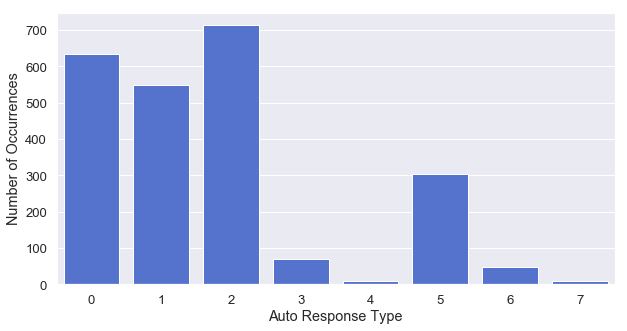

In [29]:
# The distribution of auto responses across all email tickets.
auto_counts = training.groupby('Auto_Response').Category.count().values[:]
print(auto_counts)
response = np.arange(0,8,1)

sns.set(style='whitegrid')
sns.set(font_scale=1.2)

f, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=response,y=auto_counts,color='royalblue')
ax.set_xlabel('Auto Response Type')
ax.set_ylabel('Number of Occurrences')

# III. Training a Classifier (Naive Bayes)

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Split the data randomly into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(training['Message'], training['Script_Title'], random_state = 0)

# Word counts in messages (Count Vectorizer) that are then converted to term frequencies (tf-idf).
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Naive Bayes Classifier
clf = MultinomialNB().fit(X_train_tfidf, y_train)

## Single Predictions After Fitting the Training Set with Naive Bayes

In [31]:
training['Message'].values[2222]

'SEO hi info\n\nHere is the plan\nhttp://www.conversionseo.co/\n\nIna Maltby'

In [32]:
print(clf.predict(count_vect.transform(['SEO hi info\n\nHere is the plan\nhttp://www.'\
                                        'conversionseo.co/\n\nIna Maltby'])))

['Spam']


In [33]:
training['Script_Title'].values[2222]

'Spam'

In [34]:
training['Message'].values[2000]

'6O4956 ⒈0000多種電子遊戲返水3.0‰手拵餸最高3888逢8必發特碼48.89倍，天天限琻大回饋'

In [35]:
print(clf.predict(count_vect.transform([training['Message'].values[2000]])))

['Spam']


In [36]:
training['Message'].values[51]

"Caregivers Core Training - Everett Hello,\n\nI see that you have a caregivers core training event in Everett, starting\n2/15/18, however I don't see any other sessions scheduled for the Everett\narea. Are you able to confirm when the next session in Everett will be\nstarting? Or can you advise when the website will be updated with other\ndates scheduled for  2018 for other venues?\n\nThanks"

In [37]:
print(clf.predict(count_vect.transform(["Caregivers Core Training - Everett Hello,\n\nI see "\
                                        "that you have a caregivers core training event in Everett,"\
                                        " starting\n2/15/18, however I don't see any other"\
                                        "sessions scheduled for the Everett\narea. Are you able"\
                                        "to confirm when the next session in Everett will be\nstarting?"\
                                        " Or can you advise when the website will be updated with"\
                                        "other\ndates scheduled for  2018 for other venues?\n\nThanks"])))

['No Scripted Response']


In [38]:
training['Script_Title'].values[51]

'No Scripted Response'

# IV. Machine Learning Model Performance Evaluation

## Naive Bayes Performance Evaluation

In [39]:
from sklearn.pipeline import Pipeline

# Use pipeline class to ease conversion from word counts --> term frequencies --> Naive Boyes classifier.
text_clf = Pipeline([('vect',CountVectorizer()),('tfidf',TfidfTransformer()),('clf',MultinomialNB())])
text_clf.fit(X_train,y_train)

# Evaluate predictive accuracy of the model
predicted = text_clf.predict(X_test)
NB_accuracy = np.round(np.mean(predicted == y_test)*100,4)
print('MultinomialNB accuracy = ' + str(NB_accuracy)+'%')

MultinomialNB accuracy = 72.4786%


## Other Model Evaluations (Random Forest, Linear Support Vector Machine, Logistic Regression)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

models = [RandomForestClassifier(n_estimators=200,max_depth=3,random_state=0),LinearSVC(),\
          LogisticRegression(random_state=0),SGDClassifier(loss='hinge',penalty='l2',\
                                                           alpha=0.001, random_state=0,\
                                                           max_iter=5, tol=None)]
accuracy = np.zeros(5)
accuracy[0]= NB_accuracy

for i in range(len(models)):
    text_clf = Pipeline([('vect',CountVectorizer()),('tfidf',TfidfTransformer()),('clf',models[i])])
    text_clf.fit(X_train,y_train)
    predicted = text_clf.predict(X_test)
    accuracy[i+1] = np.round(np.mean(predicted == y_test)*100,4)
model_results = pd.DataFrame({'Model_Name': ['Multinomial NB','Random Forest','Linear SVC',\
                                             'Logistic Regression','SGD Classifier'],'Accuracy' : accuracy})
model_results

C:\Users\CASTAFF\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\CASTAFF\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\CASTAFF\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


,Model_Name,Accuracy
0,Multinomial NB,72.4786
1,Random Forest,58.6325
2,Linear SVC,84.7863
3,Logistic Regression,82.5641
4,SGD Classifier,84.7863


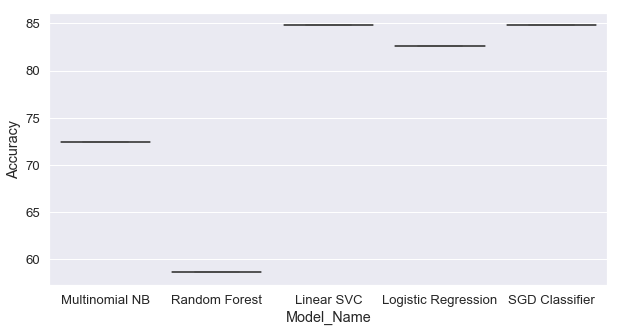

In [41]:
# Graph the accuracy findings.
f, ax = plt.subplots(figsize=(10,5))
ax = sns.boxplot(x=model_results['Model_Name'],y=model_results['Accuracy'])

# V. Confusion Matrix for Linear SVC Model

Accuracy = 84.9935%


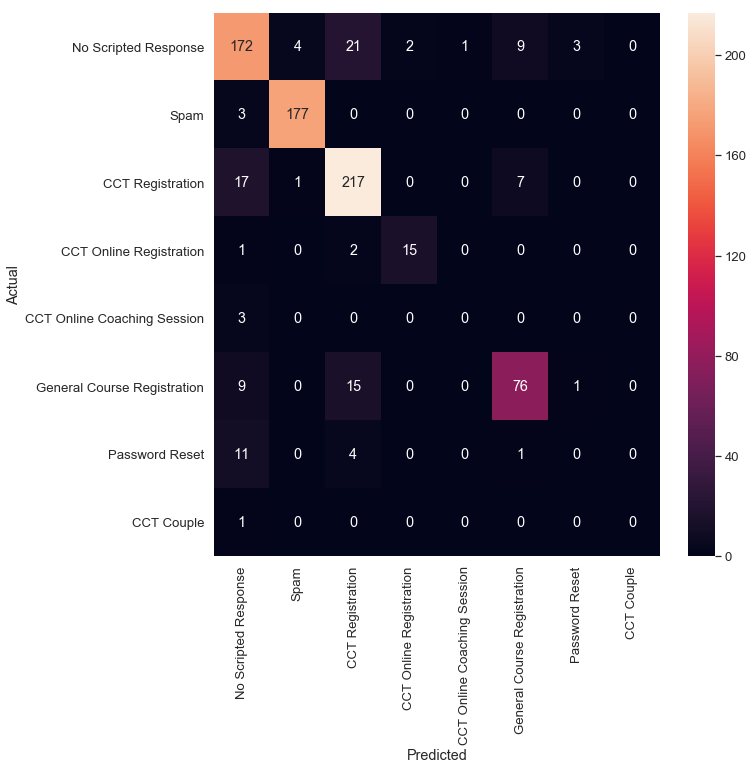

In [42]:
# Produce a confusion matrix to show discrepancies between model and results.
from sklearn.metrics import confusion_matrix

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(training['Message'],\
                                                            training['Script_Title'],\
                                                            test_size = 0.33,random_state = 0)
text_clf = Pipeline([('vect',CountVectorizer()),('tfidf',TfidfTransformer()),('clf',LinearSVC())])
text_clf.fit(X_train_2,y_train_2)
y_predicted = text_clf.predict(X_test_2)
script_responses = training[['Auto_Response','Script_Title']].drop_duplicates().\
                   sort_values('Auto_Response').Script_Title.values
print('Accuracy = ' + str(np.round(np.mean(y_predicted == y_test_2)*100,4)) + '%')

conf_mat = confusion_matrix(y_test_2, y_predicted,labels=script_responses)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat,annot=True,fmt='d',xticklabels=script_responses, yticklabels=script_responses)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# VI. Testing with Real Incoming Tickets

In [43]:
# Import new tickets from the day.
df = pd.read_csv('new_tickets.csv',encoding='ANSI')
voicemail_tickets = df['Summary'].str.contains('Voice msg')
email_tickets = df[~voicemail_tickets]
new_tickets = email_tickets[['Created On','Ticket Number','Summary','Description','Auto Response Used']]

# Concatenate the Summary and Description into a Message.
messages = []
for i in range(len(new_tickets)):
    message = new_tickets['Summary'].values[i] + ' ' + new_tickets['Description'].values[i]
    messages.append(message)
new_tickets.insert(3,'Message',messages)
incoming = new_tickets.drop(columns=['Summary','Description'])

# Change the date/time in 'Created On' column to be just the date and drop the time.
from datetime import datetime
month_year = []
for i in range(len(incoming)):
    raw_date = incoming['Created On'].values[i].split(" ")[0]
    date = datetime.strptime(raw_date,"%m/%d/%Y").strftime('%m/%d/%Y')
    month_year.append(date)
incoming.insert(1,'Date',month_year)
incoming = incoming.drop(columns=['Created On'])
incoming.iloc[0:3]

,Date,Ticket Number,Message,Auto Response Used
0,03/20/2019,7960,Outstanding Offer For Dell EMC World Exhibitor...,SPAM
1,03/20/2019,7961,Form submission from: Caregiver Registration H...,8
2,03/20/2019,7962,Form submission from: Caregiver Registration H...,5


In [44]:
# Train the model with all previous caregiver tickets.

incoming_clf = Pipeline([('vect',CountVectorizer()),('tfidf',TfidfTransformer()),('clf',LinearSVC())])
incoming_clf.fit(training['Message'],training['Script_Title'])

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [45]:
# Test the model against the new tickets. Create dataframe for the day's tickets and human response.
responses(incoming)
predicted_script = incoming_clf.predict(incoming['Message'])
incoming['Predicted_Script'] = predicted_script

# Add column that signifies whether the program predicted the correct response (as determined by a human).
correct_response = np.zeros(len(incoming))
for i in range(len(incoming)):
    if incoming['Script_Title'].values[i] == incoming['Predicted_Script'].values[i]:
        correct_response[i] = 1
    else: #incoming['Script_Title'].values[i] != incoming['Predicted_Script'].values[i]
        correct_response[i] = 0
incoming['Correct Response'] = correct_response
incoming.iloc[0:3]

,Date,Ticket Number,Message,Auto Response Used,Auto_Response,Script_Title,Predicted_Script,Correct Response
0,03/20/2019,7960,Outstanding Offer For Dell EMC World Exhibitor...,SPAM,1.0,Spam,Spam,1.0
1,03/20/2019,7961,Form submission from: Caregiver Registration H...,8,5.0,General Course Registration,General Course Registration,1.0
2,03/20/2019,7962,Form submission from: Caregiver Registration H...,5,3.0,CCT Online Registration,CCT Online Registration,1.0


In [46]:
# Calculate the daily and total moving accuracy.

# Create a dictionary that pairs dates with the total number of tickets that were correct.
accuracy_counts = {}
total_counts = {}
for i in range(len(incoming)):
    date = incoming['Date'].values[i]
    if date in accuracy_counts:
        accuracy_counts[date] += incoming['Correct Response'].values[i]
        total_counts[date] += 1
    else: # date not in dates
        accuracy_counts[date] = incoming['Correct Response'].values[i]
        total_counts[date] = 1

# Calculate the accuracy for each date and add to a DataFrame.
daily_accuracy = []
dates = []
daily_results = pd.DataFrame()
for date in accuracy_counts:
    num_tickets = total_counts[date]
    correct_tickets = accuracy_counts[date]
    daily_accuracy.append(correct_tickets / num_tickets * 100)
    dates.append(date)
daily_results['Dates'] = dates
daily_results['Daily Accuracy (%)'] = daily_accuracy

# Calculate the overall moving accuracy.
moving_accuracy = []
for date in accuracy_counts:
    date_filter = incoming['Date'] <= date
    past_dates = incoming[date_filter]
    correct_count = sum(past_dates['Correct Response'])
    total_tickets = len(past_dates)
    moving_accuracy.append(np.round(correct_count / total_tickets * 100,1))
daily_results.insert(2,'Moving Accuracy (%)', moving_accuracy)
daily_results

,Dates,Daily Accuracy (%),Moving Accuracy (%)
0,03/20/2019,100.0,100.0
1,03/21/2019,50.0,83.3
2,03/22/2019,100.0,88.9
3,03/23/2019,100.0,90.9
4,03/24/2019,100.0,94.7
5,03/25/2019,100.0,95.7


In [47]:
# Calculate the total accuracy as a percent.

total_accuracy = np.round(sum(incoming['Correct Response']) / len(incoming) * 100,4)
print("The program's total accuracy on incoming tickets: " + str(total_accuracy) + "%")

The program's total accuracy on incoming tickets: 95.6522%


# VII. Summarizing the Daily Accuracy Over Time

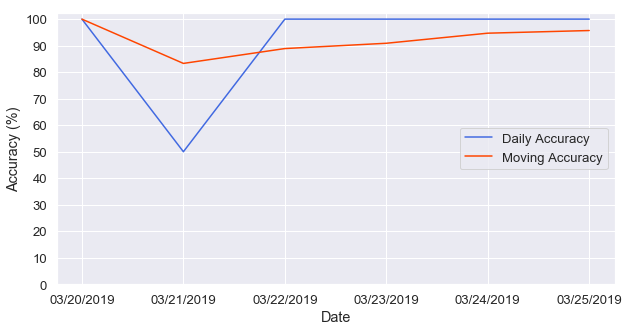

In [48]:
# Graph the daily accuracy and moving accuracy over time.
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.lineplot(x='Dates',y='Daily Accuracy (%)',data = daily_results,label='Daily Accuracy',\
                  color='royalblue')
ax = sns.lineplot(x='Dates',y='Moving Accuracy (%)',data = daily_results,label='Moving Accuracy',\
                  color='orangered')
ax.set_xlabel('Date')
ax.set_ylabel('Accuracy (%)')
ax.set_yticks(np.arange(0,110,10))
ax.legend(ncol=1,loc='center right',frameon=True)